In [1]:
#GAN(Generative Adversial Network) on CIFAR10 dataset

In [2]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

(x_train,y_train),(x_test,y_test) = load_data()

In [3]:
x_train.shape # 50k images having 32*32 width and each having 3 channgels RGB

(50000, 32, 32, 3)

In [4]:
y_train # 10 classes -> multiclass classification prob.

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

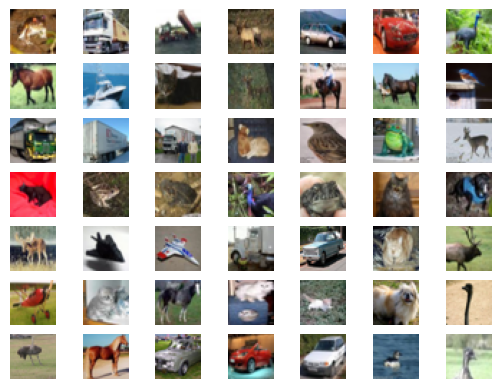

In [5]:
for i in range(49):
    pyplot.subplot(7,7,i+1);
    pyplot.axis('off');
    pyplot.imshow(x_train[i])
pyplot.show()

In [6]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd

In [7]:
# define standardize discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    
    # normal
    model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
# define model
model = define_discriminator()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

C:\Users\rahul\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
# load real samples
def load_real_samples():
    (x_train,_),(_,_) = load_data()
    X = x_train.astype('float32')
    
    # downscaling pixel value to range [-1,1]
    X = (X - 127.5)/127.5
    return X

In [10]:
# our batch size is 128, which we sent to discriminator, out of which 64 images are real and 64 are fake
# real are marked with 1 and fake with 0

In [11]:
# select real samples
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix] # n_samples images from dataset 
    y = np.ones((n_samples,1)) # all images are real
    return X,y

In [12]:
# generate n fake images with class labels
def generate_fake_samples(n_samples):
    #generate uniform random number in [0,1]
    X = np.random.rand(32*32*3*n_samples)
    # update to have the range [-1,1]
    X = -1 + X*2
    # reshape into a batch of color images
    X = X.reshape((n_samples,32,32,3))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples,1))
    return X,y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


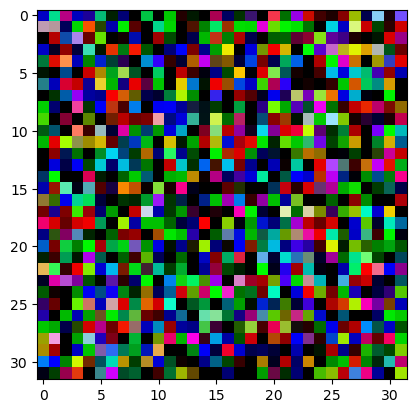

In [13]:
X,y = generate_fake_samples(64)
pyplot.imshow(X[0])

In [14]:
# train discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2)
    for i in range(n_iter):
        # generate real samples
        x_real,y_real = generate_real_samples(dataset,half_batch)
        
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(x_real,y_real)
        
        # generate 'fake' samples
        x_fake,y_fake = generate_fake_samples(half_batch)
        
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(x_fake,y_fake)
        
        # summarize
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [15]:
#define discriminator model
model = define_discriminator()
dataset = load_real_samples()
train_discriminator(model,dataset)

>1 real=25% fake=8%
>2 real=84% fake=20%
>3 real=81% fake=42%
>4 real=78% fake=81%
>5 real=84% fake=98%
>6 real=84% fake=100%
>7 real=72% fake=100%
>8 real=81% fake=100%
>9 real=78% fake=100%
>10 real=73% fake=100%
>11 real=81% fake=100%
>12 real=84% fake=100%
>13 real=86% fake=100%
>14 real=94% fake=100%
>15 real=97% fake=100%
>16 real=98% fake=100%
>17 real=100% fake=100%
>18 real=97% fake=100%
>19 real=100% fake=100%
>20 real=97% fake=100%


In [16]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose #upscaling

In [17]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential();
    
    # foundation of 4*4 image
    n_nodes = 256*4*4
    model.add(Dense(n_nodes,input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2)) # small negative slope
    model.add(Reshape((4,4,256))) # 4*4 image with 256 channels
    
    # upsample to 8*8
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16*16
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32*32
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer
    model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
    return model

In [18]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [19]:
# generate points in latent space as input for the generator
# we sent 64 vectors of 100 dim
# it returns 64 images of size (32,32,3)
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim*n_samples);
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input

In [20]:
def generate_fake_samples(g_model,latent_dim,n_samples):
    x_input = generate_latent_points(latent_dim,n_samples)
    # sent n_samples number of vectors of dim latent_dim
    # receive n_samples number of images of dim 32*32*3
    X = g_model.predict(x_input)
    y = np.zeros((n_samples,1))
    return X,y

In [21]:
# merge discriminator and generator
def define_gan(g_model,d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr = 0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [22]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model,d_model)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [27]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=250, n_batch=128):
    half_batch = int(n_batch/2);
    batch_per_epo = int(dataset.shape[0]/(20*n_batch))
    count = 1;
    for i in range(0,n_epochs): # 250
        for j in range(batch_per_epo): # 50K/(2*1280)
            # (50K*250)/(2*1280) = (9765.625/2) = 4882.8
            x_real,y_real = generate_real_samples(dataset,half_batch);
            _,_ = d_model.train_on_batch(x_real,y_real)
            x_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
            _,_ = d_model.train_on_batch(x_fake,y_fake)
            x_gan = generate_latent_points(latent_dim,n_batch)
            y_gan = np.ones((n_batch,1))
            g_loss = gan_model.train_on_batch(x_gan,y_gan)
            print("count: ",count)
            count = count + 1;

In [28]:
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=250,n_batch=128)

2/2 [==============================] - 0s 124ms/step
count:  1
2/2 [==============================] - 0s 115ms/step
count:  2
2/2 [==============================] - 0s 90ms/step
count:  3
2/2 [==============================] - 0s 112ms/step
count:  4
2/2 [==============================] - 0s 92ms/step
count:  5
2/2 [==============================] - 0s 119ms/step
count:  6
2/2 [==============================] - 0s 93ms/step
count:  7
2/2 [==============================] - 0s 126ms/step
count:  8
2/2 [==============================] - 0s 115ms/step
count:  9
2/2 [==============================] - 0s 94ms/step
count:  10
2/2 [==============================] - 0s 149ms/step
count:  11
2/2 [==============================] - 0s 109ms/step
count:  12
2/2 [==============================] - 0s 117ms/step
count:  13
2/2 [==============================] - 0s 90ms/step
count:  14
2/2 [==============================] - 0s 97ms/step
count:  15
2/2 [==============================] - 0s 179ms/step
co

1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


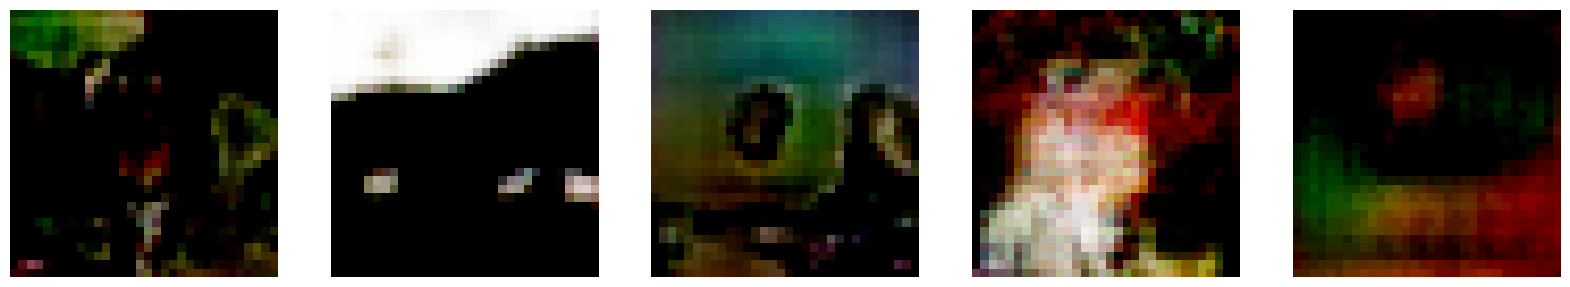

In [29]:
n = 5
x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n)
fig, axs = pyplot.subplots(1, n, figsize=(20, 5))
for i in range(n):
    axs[i].imshow(x_fake[i])
    axs[i].axis('off')
pyplot.show()